###Introduction to Data

Variables:
- X: x-axis coordinate within the park (int, 1-9)
- Y: y-axis coordinate within the park (int, 2-9)
- month: month of the year (string)
- day: day of the week (string)
- FFMC: Fine Fuel Moisture Code, moisture content in litter and other fine fuels. Indicates how easily fine fuel ignites and burns. (double)
- DMC: Duff Moisture Code, moisture content in duff (coniferous needles, lightly compacted on the ground, see: https://en.wikipedia.org/wiki/Wildfire#Spread) (double).
- DC: Drought Code, avg moisture of deep, organic layers. Useful to understand drought effects on fuel in forest
- ISI: Initial Spread Index, expected rate of fire spread, based on wind and FFMC, but does not take fuel types into account
- temp: temperature in degrees Celsius
- RH: relative humidity, %
- wind: wind speed, km/h
- rain: amount of rain in millimeters/square meter
- area: TARGET VARIABLE, the burned area of the forest sector in hectares (10,000 square meters, 1/100th of a square kilometer)


Additionally, see https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi
https://archive.ics.uci.edu/dataset/162/forest+fires

Persona: Our aim is to calculate the risk of forest fires and predict whether an area, given certain environmental factors, is likely to be heavily affected by fire. Although our dataset only includes data on one park, the results of this project can be applied to other forest locations as we build up a comprehensive understanding of our data variables and their impact on forest fire predictions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("drive/MyDrive/Ian_PBIML")

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('forestfires.csv')

In [4]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


###EDA

In [5]:
data['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

In [6]:
import matplotlib.pyplot as plt

def feature_bar(column):
  plt.bar(list(data[column].value_counts().keys()), list(data[column].value_counts()))
  plt.xlabel(column)
  plt.ylabel('Count')
  plt.title('Bar Graph of '+column)
  plt.xticks(rotation=70)
  plt.show()

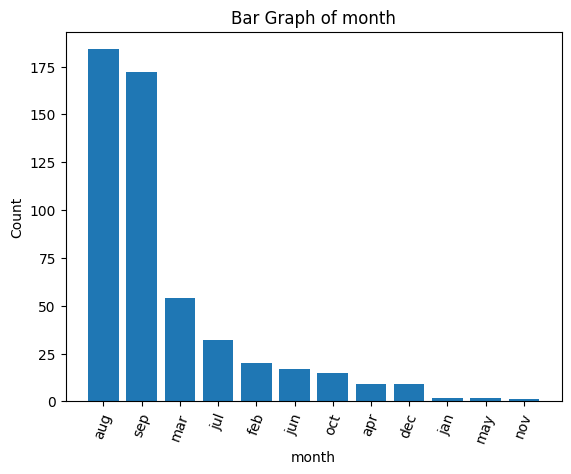

In [7]:
feature_bar('month')

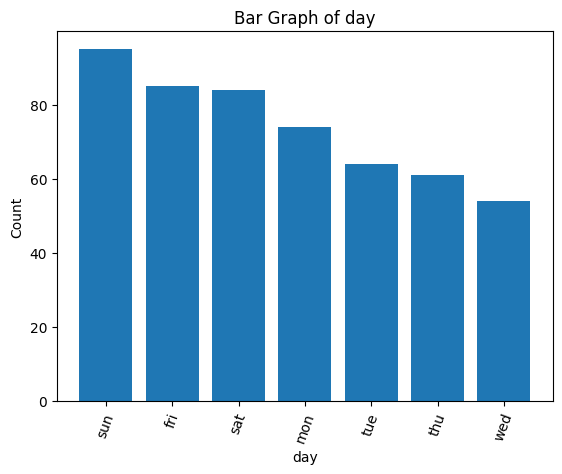

In [8]:
feature_bar('day')

We will drop this column, does not provide important information for predictions

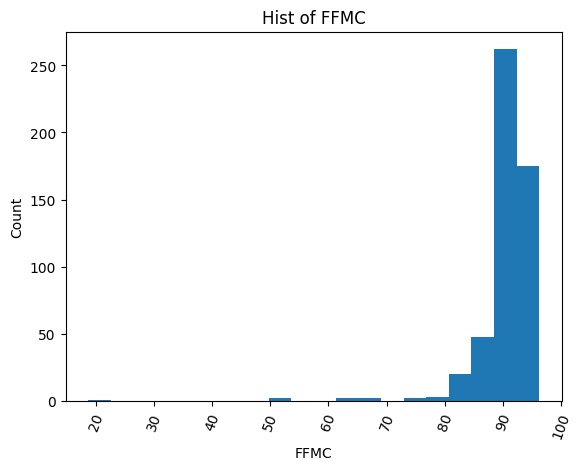

In [9]:
column = 'FFMC'
plt.hist(data[column],bins=20)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

left skewed

In [10]:
data[data['FFMC']<70]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
12,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0.0,0.00
97,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0.0,0.00
130,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0.0,0.00
199,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0.0,11.32
299,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0.0,0.00
312,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0.0,0.00
379,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00


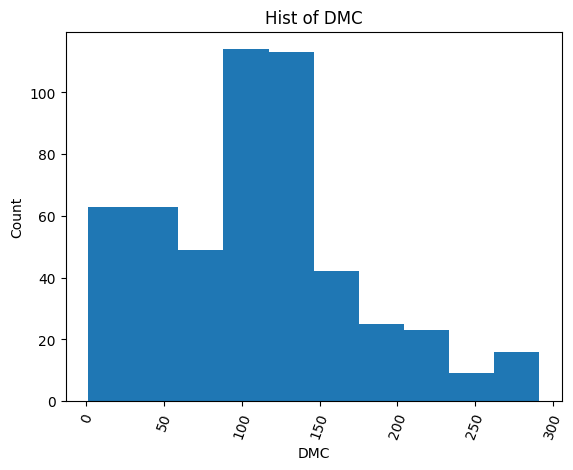

In [11]:
column = 'DMC'
plt.hist(data[column],bins=10)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

sort of right skewed, possibly bimodal?

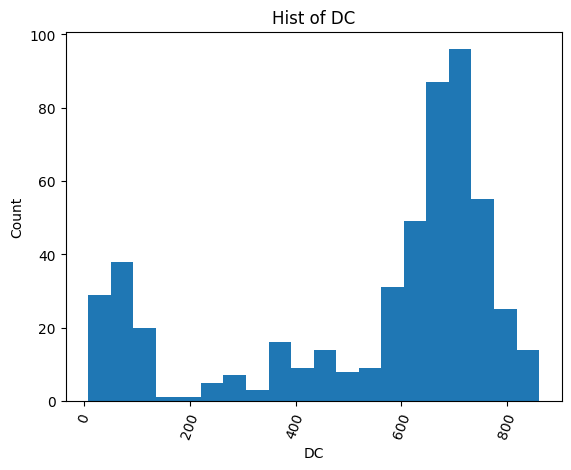

In [12]:
column = 'DC'
plt.hist(data[column],bins=20)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

bimodal

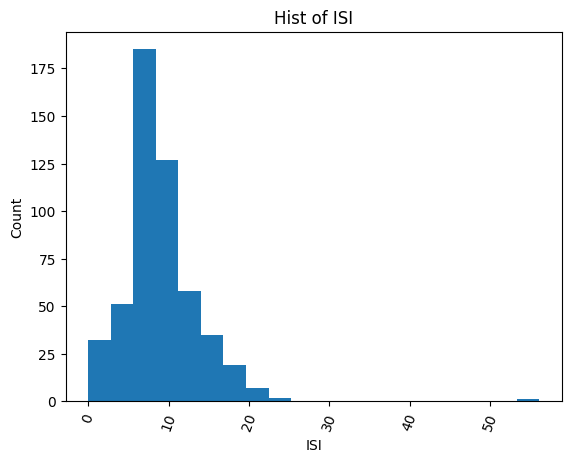

In [13]:
column = 'ISI'
plt.hist(data[column],bins=20)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

In [14]:
data[data['ISI']>30]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.0


sort of right skewed, outlier above 50 greatly affects how normalized the distribution is

###Data Preprocessing

One-hot encode months, eventually use feature selection to eliminate several of our month columns so that we are just left with the months that are important to predicting for forest fires (typically July to Sept)

In [15]:
fire_season = []
fire_season_months = ['jul', 'aug', 'sep']

for index, row in data.iterrows():
  fire_season.append(int(row['month'] in fire_season_months))


data['fire season'] = fire_season

In [16]:
# data = pd.get_dummies(data, columns=['month'], drop_first=True) # RUN ONCE

Remove X and Y columns because they are just identifiers for the observations, and they are not useful indications for forest fires

In [17]:
try:
  data = data.drop(columns=['X','Y','day', 'month'])
except:
  pass

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FFMC         517 non-null    float64
 1   DMC          517 non-null    float64
 2   DC           517 non-null    float64
 3   ISI          517 non-null    float64
 4   temp         517 non-null    float64
 5   RH           517 non-null    int64  
 6   wind         517 non-null    float64
 7   rain         517 non-null    float64
 8   area         517 non-null    float64
 9   fire season  517 non-null    int64  
dtypes: float64(8), int64(2)
memory usage: 40.5 KB


In [19]:
for index, row in data.iterrows():
  if row['area'] == 0:
    row['area'] = 0
  else:
    row['area'] = 1

In [20]:
data['area'].value_counts()

area
0.00      247
1.94        3
0.52        2
3.71        2
0.68        2
         ... 
105.66      1
154.88      1
196.48      1
200.94      1
11.16       1
Name: count, Length: 251, dtype: int64

In [21]:
# data['FFMC'] = np.log(data['FFMC'])

In [22]:
from scipy.stats import boxcox

data['FFMC'], _ = boxcox(data['FFMC'])

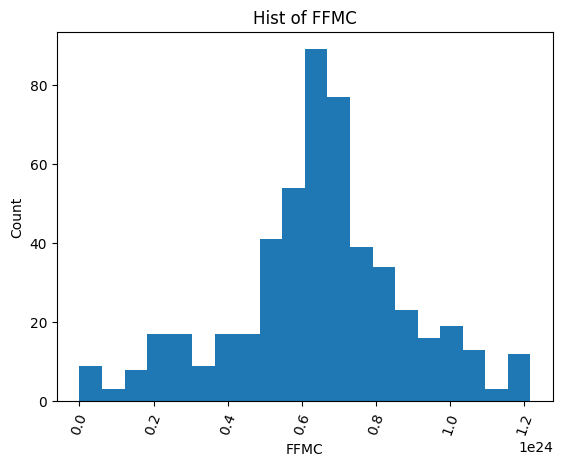

In [23]:
column = 'FFMC'
plt.hist(data[column],bins=20)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

In [24]:
data['DMC'], _ = boxcox(data['DMC'])

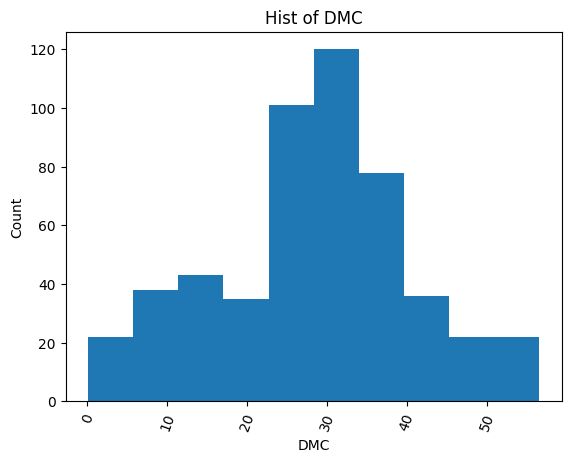

In [25]:
column = 'DMC'
plt.hist(data[column],bins=10)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

In [26]:
data['DC'], _ = boxcox(data['DC'])

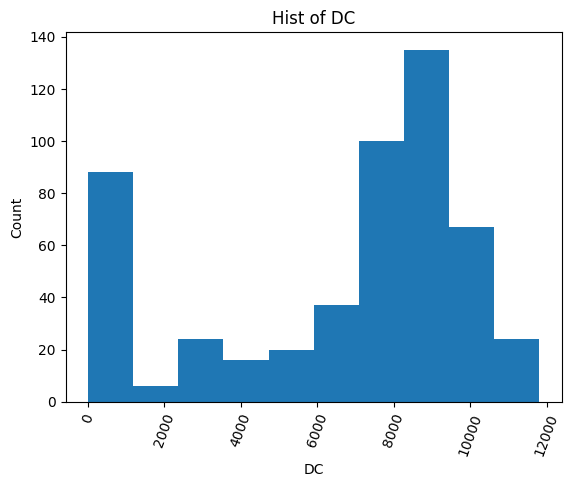

In [27]:
column = 'DC'
plt.hist(data[column],bins=10)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

In [28]:
data = data[data['ISI']<30]

In [29]:
from scipy.stats import yeojohnson

data['ISI'], _ = yeojohnson(data['ISI'])

<ipython-input-29-6d98f5716610>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ISI'], _ = yeojohnson(data['ISI'])


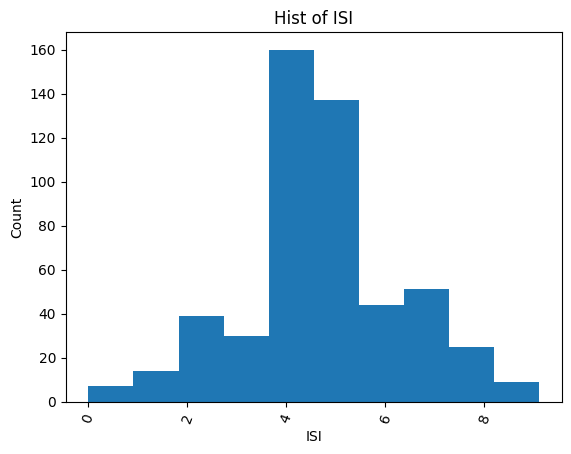

In [30]:
column = 'ISI'
plt.hist(data[column],bins=10)
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Hist of '+column)
plt.xticks(rotation=70)
plt.show()

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data['FFMC'] = scaler.fit_transform(data[['FFMC']])

In [32]:
data['FFMC'].describe()

count    516.000000
mean       0.532793
std        0.194346
min        0.000000
25%        0.441330
50%        0.536687
75%        0.641884
max        1.000000
Name: FFMC, dtype: float64

In [33]:
data['DMC'] = scaler.fit_transform(data[['DMC']])

In [34]:
data['DC'] = scaler.fit_transform(data[['DC']])

In [35]:
data['ISI'] = scaler.fit_transform(data[['ISI']])

In [36]:
from scipy.stats import boxcox
from scipy.stats import yeojohnson

# data['FFMC'], _ = boxcox(data['FFMC'])
# data['DMC'], _ = boxcox(data['DMC'])
# data['DC'], _ = boxcox(data['DC'])
# data['ISI'], _ = yeojohnson(data['ISI'])
data['temp'], _ = boxcox(data['temp'])
data['RH'], _ = boxcox(data['RH'])
data['wind'], _ = boxcox(data['wind'])

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# data['FFMC'] = scaler.fit_transform(data[['FFMC']])
# data['DMC'] = scaler.fit_transform(data[['DMC']])
# data['DC'] = scaler.fit_transform(data[['DC']])
# data['ISI'] = scaler.fit_transform(data[['ISI']])
data['temp'] = scaler.fit_transform(data[['temp']])
data['RH'] = scaler.fit_transform(data[['RH']])
data['wind'] = scaler.fit_transform(data[['wind']])

In [38]:
is_burned = []

for index, row in data.iterrows():
  is_burned.append(int(row['area'] != 0))

data['area'] = is_burned
data.rename(columns={'area': 'burned'}, inplace=True)

In [39]:
data['burned'].value_counts()

burned
1    270
0    246
Name: count, dtype: int64

###Establishing the Model: Logistic Regression

In [40]:
from sklearn.model_selection import train_test_split
input_features = data.drop(columns=['burned'])
target = data['burned']

X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2, stratify = target, random_state=42)

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=45,max_iter =10000,solver='liblinear')

liblinear suits smaller datasets

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 516
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FFMC         516 non-null    float64
 1   DMC          516 non-null    float64
 2   DC           516 non-null    float64
 3   ISI          516 non-null    float64
 4   temp         516 non-null    float64
 5   RH           516 non-null    float64
 6   wind         516 non-null    float64
 7   rain         516 non-null    float64
 8   burned       516 non-null    int64  
 9   fire season  516 non-null    int64  
dtypes: float64(8), int64(2)
memory usage: 44.3 KB


In [43]:
# Train the classifier on the training data
clf.fit(X_train, y_train)


# Make predictions on the train data
y_train_pred = clf.predict(X_train)

# Make predictions on the test data
y_test_pred = clf.predict(X_test)

In [44]:
y_probs = clf.predict_proba(X_train)[:,1]
print(y_probs)

[0.54556346 0.55187615 0.53967739 0.4783957  0.57914343 0.4709231
 0.59731263 0.50057285 0.55597038 0.56655789 0.59973712 0.57505727
 0.5666343  0.52521251 0.53302266 0.56816058 0.52242351 0.51114268
 0.52616539 0.5045531  0.53229912 0.53494651 0.51303748 0.56424437
 0.49384728 0.54101483 0.5815226  0.51075525 0.56000789 0.47901684
 0.53136835 0.56529329 0.43153662 0.46495242 0.51109564 0.47317181
 0.5650221  0.47365207 0.47605165 0.53789137 0.52680293 0.56411554
 0.53084962 0.50357206 0.55088392 0.55587367 0.5669565  0.49528631
 0.56547874 0.52684058 0.55697004 0.57215181 0.53146009 0.5675094
 0.51139504 0.43538503 0.57825534 0.53257134 0.5258638  0.57325745
 0.51736975 0.46412702 0.55723678 0.45690378 0.57454116 0.55292324
 0.58312472 0.44511247 0.52075701 0.52607609 0.56380829 0.5106462
 0.53132801 0.5501539  0.53896368 0.55771064 0.5561326  0.48286631
 0.56087883 0.49555591 0.55271984 0.53628819 0.59313743 0.48106478
 0.5093768  0.44316297 0.45963113 0.47744994 0.5669218  0.4172608

In [45]:
decision_threshold = 0.6
predictions = [1 if pred_ >= decision_threshold else 0 for pred_ in y_probs]

In [46]:
from sklearn.metrics import *

print(f"Accuracy (Train set): {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy (Test set): {accuracy_score(y_test, y_test_pred)}")
print(f"Accuracy score: {accuracy_score(y_train,predictions)}")

Accuracy (Train set): 0.5436893203883495
Accuracy (Test set): 0.5865384615384616
Accuracy score: 0.47815533980582525


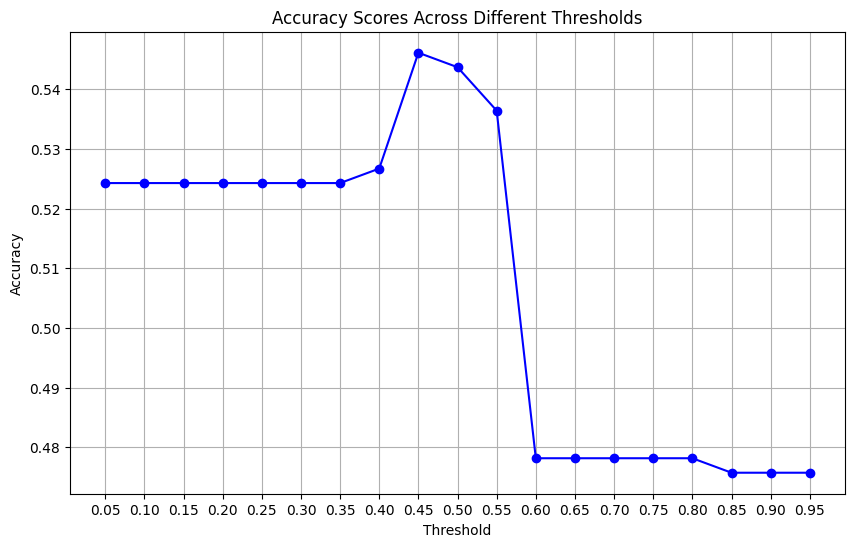

In [47]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
accuracies = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    accuracies.append(accuracy_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

In [48]:
print(f"Precision (Train set): {precision_score(y_train, y_train_pred)}")
print(f"Precision (Test set): {precision_score(y_test, y_test_pred)}")

Precision (Train set): 0.5454545454545454
Precision (Test set): 0.5753424657534246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


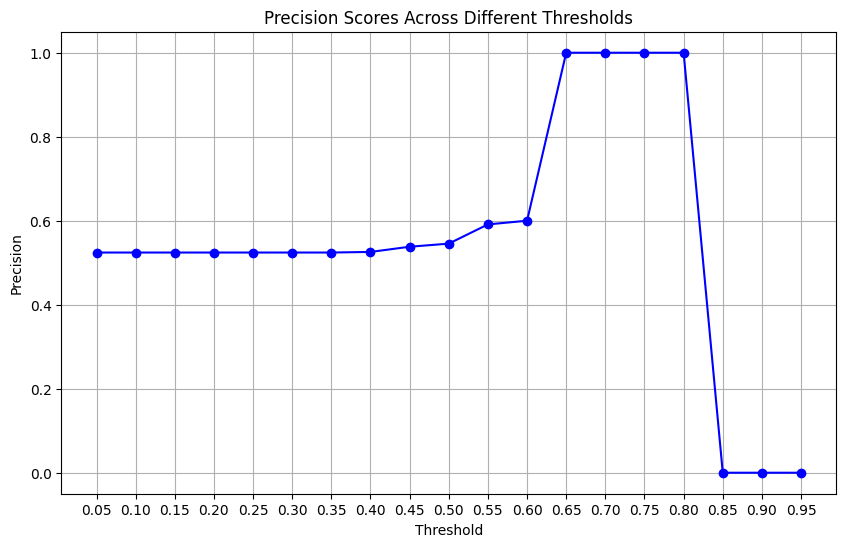

In [49]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
precision = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    precision.append(precision_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, marker='o', linestyle='-', color='b')
plt.title('Precision Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

In [50]:
print(f"Recall (Train set): {recall_score(y_train, y_train_pred)}")
print(f"Recall (Test set): {recall_score(y_test, y_test_pred)}")

Recall (Train set): 0.7777777777777778
Recall (Test set): 0.7777777777777778


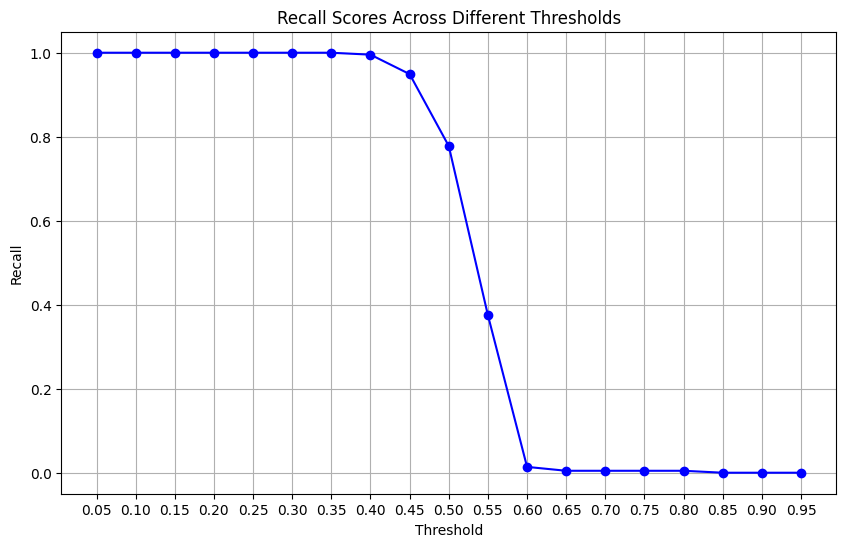

In [51]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
recall = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    recall.append(recall_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, marker='o', linestyle='-', color='b')
plt.title('Recall Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

In [52]:
print(f"F1 Score (Train set): {f1_score(y_train, y_train_pred)}")
print(f"F1 Score (Test set): {f1_score(y_test, y_test_pred)}")

F1 Score (Train set): 0.6412213740458015
F1 Score (Test set): 0.6614173228346456


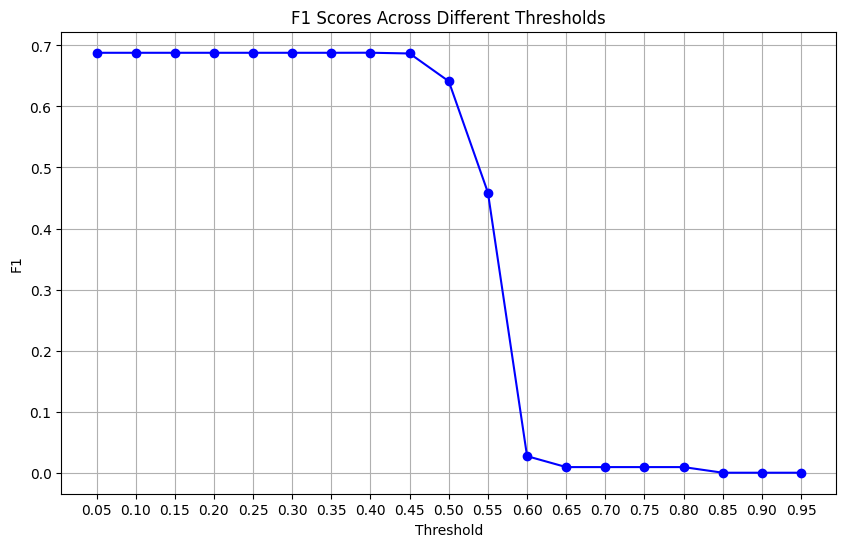

In [53]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
f1 = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    f1.append(f1_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1, marker='o', linestyle='-', color='b')
plt.title('F1 Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

In [54]:
print(f"ROC AUC Score (Train set): {roc_auc_score(y_train, y_train_pred)}")
print(f"ROC AUC Score (Test set): {roc_auc_score(y_test, y_test_pred)}")

ROC AUC Score (Train set): 0.5317460317460317
ROC AUC Score (Test set): 0.5788888888888889


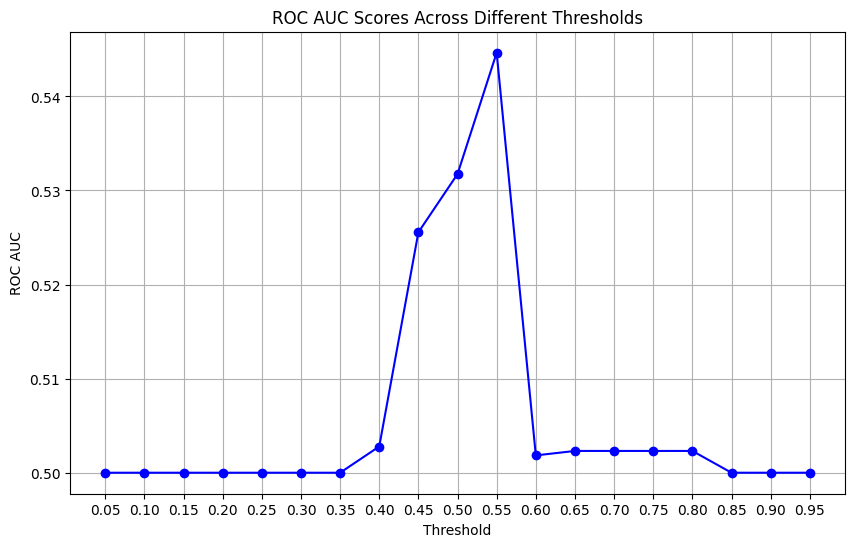

In [55]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
auc = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    auc.append(roc_auc_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, auc, marker='o', linestyle='-', color='b')
plt.title('ROC AUC Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

In [56]:
print(f"Log Loss (Train set): {log_loss(y_train, y_train_pred)}")
print(f"Log Loss (Test set): {log_loss(y_test, y_test_pred)}")

Log Loss (Train set): 16.447103973674817
Log Loss (Test set): 14.902664382038823


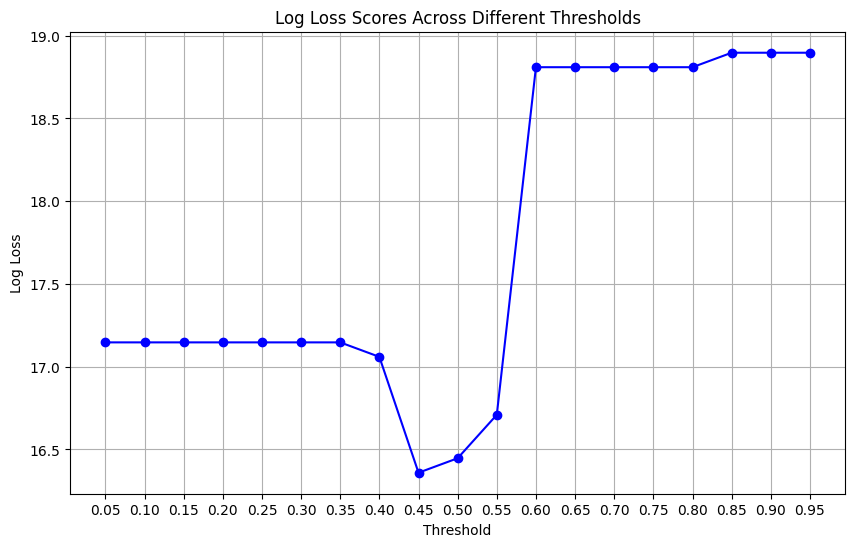

In [57]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
log_l = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    log_l.append(log_loss(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, log_l, marker='o', linestyle='-', color='b')
plt.title('Log Loss Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Log Loss')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

Make threshold 0.45

In [58]:
y_probs = clf.predict_proba(X_test)[:,1]
print(y_probs)
decision_threshold = 0.45
predictions = [1 if pred_ >= decision_threshold else 0 for pred_ in y_probs]
print(f"Accuracy score: {accuracy_score(y_test,predictions)}")
print(f"Precision score: {precision_score(y_test,predictions)}")
print(f"Recall score: {recall_score(y_test,predictions)}")
print(f"F1 score: {f1_score(y_test,predictions)}")
print(f"ROC AUC score: {roc_auc_score(y_test,predictions)}")
print(f"Log loss score: {log_loss(y_test,predictions)}")

[0.45310808 0.52155244 0.5490191  0.55802876 0.50321809 0.48339155
 0.56600846 0.56530865 0.42615726 0.51291355 0.57813537 0.48557101
 0.5459537  0.56927565 0.53370229 0.5296181  0.59764713 0.52015708
 0.53328007 0.60329106 0.47605046 0.5476246  0.47567396 0.57141266
 0.56895985 0.4865616  0.53025792 0.49483353 0.50404544 0.5158453
 0.55166333 0.51311905 0.49179316 0.47317181 0.53721268 0.5025759
 0.52726932 0.59831107 0.58345004 0.5696244  0.55931737 0.49019517
 0.58881545 0.54847152 0.50162105 0.5821504  0.53084945 0.46492653
 0.55153828 0.45831072 0.57043943 0.50688466 0.42394504 0.52781617
 0.52121717 0.52516131 0.46863222 0.56655432 0.4546461  0.432847
 0.40569222 0.41652884 0.58131508 0.58345004 0.51973683 0.45926029
 0.5565328  0.53321495 0.53190985 0.48401549 0.52853625 0.51384981
 0.49583203 0.52263932 0.50351    0.54997265 0.47278173 0.56839221
 0.59238312 0.49777958 0.5276553  0.53256291 0.49384728 0.46393745
 0.5501101  0.55257519 0.60721653 0.53131524 0.55407337 0.55413007

###Hyperparameter Tuning (Logistic Regression)

In [59]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [60]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

In [61]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

In [62]:
print(best_params_grid)
print(best_score_grid)

{'C': 0.001, 'penalty': 'l2'}
0.524272700558331


In [63]:
clf.set_params(penalty = 'l2', C=0.001)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Precision: {precision_score(y_train, y_train_pred)}')
print(f'Recall: {recall_score(y_train, y_train_pred)}')
print(f'F1 Score: {f1_score(y_train, y_train_pred)}')
print(f'ROC AUC: {roc_auc_score(y_train, y_train_pred)}')
print(f'Log Loss: {log_loss(y_train, y_train_pred)}')

Accuracy: 0.5242718446601942
Precision: 0.5242718446601942
Recall: 1.0
F1 Score: 0.6878980891719745
ROC AUC: 0.5
Log Loss: 17.146980738512042


In [64]:
clf.fit(X_test,y_test)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Log Loss: {log_loss(y_test, y_pred)}')

Accuracy: 0.5192307692307693
Precision: 0.5192307692307693
Recall: 1.0
F1 Score: 0.6835443037974684
ROC AUC: 0.5
Log Loss: 17.32867951399863


use on train set first, and then apply to test set
validation set

###Feature Importance (Random Forest)

In [65]:
from sklearn.ensemble import RandomForestClassifier

for x in np.arange(10,100,10):
  RF_classifier =  RandomForestClassifier(n_estimators=x)
  RF_classifier.fit(X_train, y_train)
  y_pred_train = RF_classifier.predict(X_train)
  print(accuracy_score(y_train, y_pred_train))

0.9587378640776699
0.9660194174757282
0.9733009708737864
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058


In [66]:
RF_classifier =  RandomForestClassifier(n_estimators=40)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40)

In [67]:
import seaborn as sns

In [68]:
# Get feature importances
feature_importances = RF_classifier.feature_importances_

# Print the importance of each feature
for feature, importance in zip(input_features.columns, feature_importances):
  print(f"{feature}: {importance:.4f}")

FFMC: 0.1192
DMC: 0.1223
DC: 0.1307
ISI: 0.1131
temp: 0.1904
RH: 0.1753
wind: 0.1384
rain: 0.0053
fire season: 0.0053


In [69]:
def plot_feature_importance(importance, names, model_name):
  #create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  # create a dataframe using a dictionary
  data = {'feature_names':feature_names, 'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  fi_df.sort_values(by=['feature_importance'],ascending = False, inplace=True)

  #define size of bar plot
  plt.figure(figsize=(10,8))
  sns.barplot(x=fi_df['feature_importance'], y = fi_df['feature_names'])
  plt.title(model_name + "FEATURE IMPORTANCE")

  #Add chart labels
  plt.xlabel("FEATURE IMPORTANCE")
  plt.ylabel("FEATURE NAMES")

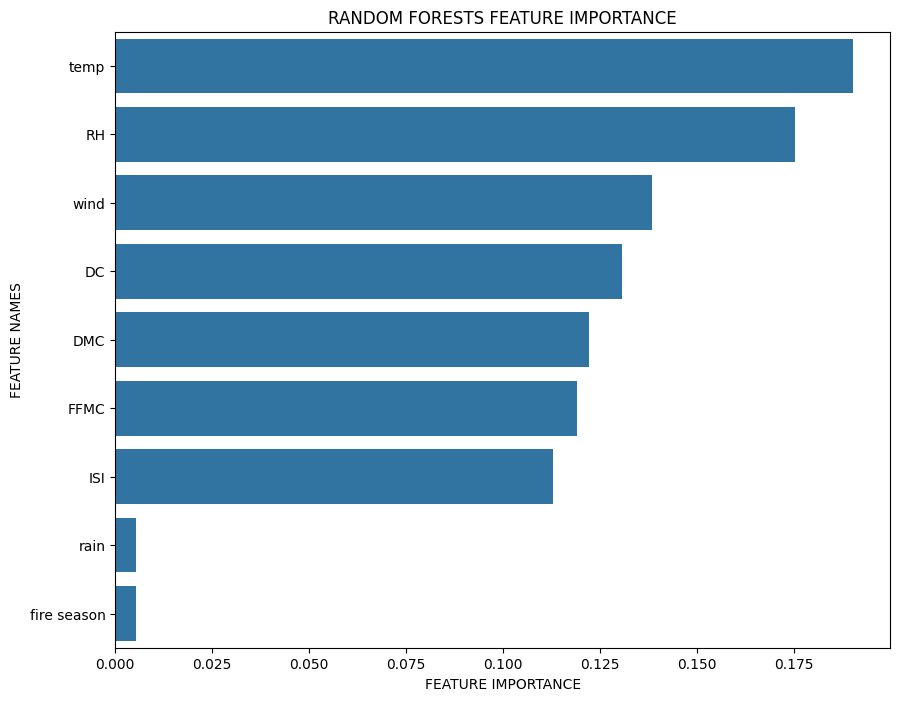

In [70]:
plot_feature_importance(feature_importances , names = input_features.columns, model_name= "RANDOM FORESTS ")

In [71]:
try:
  data = data.drop(['rain','fire season'],axis=1)
except:
  pass

In [72]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,burned
0,0.248060,0.192831,0.040160,0.351356,0.142144,0.651921,0.806892,0
1,0.466843,0.239768,0.695339,0.429670,0.441072,0.422909,0.133123,0
2,0.466843,0.278394,0.722207,0.429670,0.330678,0.422909,0.213021,0
3,0.544177,0.229489,0.029980,0.531138,0.144854,0.984414,0.567348,0
4,0.388551,0.311469,0.045241,0.555938,0.232855,0.994859,0.296627,0


###Hyperparameter Tuning (Random Forest)

In [73]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(1,10,1),
    'min_samples_split': np.arange(2,10,1),
    'max_features': ['sqrt', 'log2', None]
}

In [74]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

In [75]:
# from sklearn.model_selection import GridSearchCV

# # Create a Grid Search object
# grid_search = GridSearchCV(estimator=RF_classifier, param_grid=params, cv=skf, scoring='accuracy')

# # Fit the Grid Search to the training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from Grid Search
# best_params_grid = grid_search.best_params_
# best_score_grid = grid_search.best_score_

In [76]:
# print(best_params_grid)
# print(best_score_grid)

{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_split': 3}

Best Score: 0.5752571260652366

In [77]:
RF_classifier_2 =  RandomForestClassifier(n_estimators=40, criterion='gini', min_samples_split=3)
RF_classifier_2.fit(X_test, y_test)
y_pred = RF_classifier_2.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9903846153846154


In [78]:
RF_classifier_2.fit(X_train, y_train)
for x in range(5,100,5):
  RF_classifier_2.set_params(max_depth=x)

  # Evaluate the pruned Random Forest model
  accuracy = RF_classifier_2.score(X_train, y_train)
  print(RF_classifier_2.get_params()['max_depth'])
  print("Accuracy of pruned Random Forest:", accuracy)

5
Accuracy of pruned Random Forest: 0.9635922330097088
10
Accuracy of pruned Random Forest: 0.9635922330097088
15
Accuracy of pruned Random Forest: 0.9635922330097088
20
Accuracy of pruned Random Forest: 0.9635922330097088
25
Accuracy of pruned Random Forest: 0.9635922330097088
30
Accuracy of pruned Random Forest: 0.9635922330097088
35
Accuracy of pruned Random Forest: 0.9635922330097088
40
Accuracy of pruned Random Forest: 0.9635922330097088
45
Accuracy of pruned Random Forest: 0.9635922330097088
50
Accuracy of pruned Random Forest: 0.9635922330097088
55
Accuracy of pruned Random Forest: 0.9635922330097088
60
Accuracy of pruned Random Forest: 0.9635922330097088
65
Accuracy of pruned Random Forest: 0.9635922330097088
70
Accuracy of pruned Random Forest: 0.9635922330097088
75
Accuracy of pruned Random Forest: 0.9635922330097088
80
Accuracy of pruned Random Forest: 0.9635922330097088
85
Accuracy of pruned Random Forest: 0.9635922330097088
90
Accuracy of pruned Random Forest: 0.9635922330

In [79]:
for x in range(1,10):
  RF_classifier_2.set_params(min_samples_leaf=x)

  # Evaluate the pruned Random Forest model
  accuracy = RF_classifier_2.score(X_train, y_train)
  print(RF_classifier_2.get_params()['min_samples_leaf'])
  print("Accuracy of pruned Random Forest:", accuracy)

1
Accuracy of pruned Random Forest: 0.9635922330097088
2
Accuracy of pruned Random Forest: 0.9635922330097088
3
Accuracy of pruned Random Forest: 0.9635922330097088
4
Accuracy of pruned Random Forest: 0.9635922330097088
5
Accuracy of pruned Random Forest: 0.9635922330097088
6
Accuracy of pruned Random Forest: 0.9635922330097088
7
Accuracy of pruned Random Forest: 0.9635922330097088
8
Accuracy of pruned Random Forest: 0.9635922330097088
9
Accuracy of pruned Random Forest: 0.9635922330097088


In [80]:
RF_classifier_2.set_params(max_depth=None,min_samples_leaf=1)
RF_classifier_2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [81]:
RF_classifier_2.fit(X_train,y_train)
y_train_pred = RF_classifier_2.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Precision: {precision_score(y_train, y_train_pred)}')
print(f'Recall: {recall_score(y_train, y_train_pred)}')
print(f'F1 Score: {f1_score(y_train, y_train_pred)}')
print(f'ROC AUC: {roc_auc_score(y_train, y_train_pred)}')
print(f'Log Loss: {log_loss(y_train, y_train_pred)}')

Accuracy: 0.9684466019417476
Precision: 0.9765258215962441
Recall: 0.9629629629629629
F1 Score: 0.9696969696969696
ROC AUC: 0.9687263794406651
Log Loss: 1.1372997428604927


In [82]:
RF_classifier_2.fit(X_test,y_test)
y_pred = RF_classifier_2.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Log Loss: {log_loss(y_test, y_pred)}')

Accuracy: 0.9903846153846154
Precision: 0.9818181818181818
Recall: 1.0
F1 Score: 0.9908256880733944
ROC AUC: 0.99
Log Loss: 0.3465735902799728
